In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [96]:
# Load the dataset and split into train and test sets
filepath = "<INSERT FILE PATH>"
dengue_df = pd.read_csv(filepath)
dengue_df["date"] = pd.to_datetime(dengue_df["date"], format = '%d/%m/%Y') # Converts the column to a datetime
dengue_df.set_index("date", inplace = True)
dengue_df = dengue_df.asfreq('W-MON')
# Observe that only 2 values are missing. Fill via interpolation
dengue_df = dengue_df.interpolate()

train_dengue = dengue_df[:'2019-10-01']
test_dengue = dengue_df['2019-10-01':]

<h1>Persistence Model</h1>

In [100]:
values = DataFrame(dengue_df.cases)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
X = dataframe.values
train_size = 405
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

def model_persistence(x):
    return x

predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 1169.125


In [103]:
test_y


array([246., 228., 239., 242., 308., 322., 373., 334.])

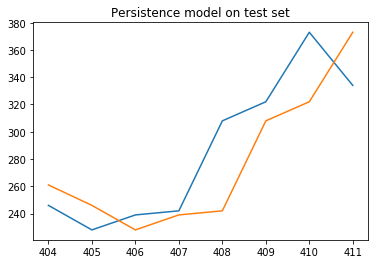

In [99]:
# pyplot.plot(train_y)
pyplot.plot([None for i in train_y] + [x for x in test_y])
pyplot.plot([None for i in train_y] + [x for x in predictions])
plt.title('Persistence model on test set')
pyplot.show()

<h1> Check if the test data is stationary via the ADF test </h1>

In [83]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(train_dengue['cases'])
print(results)
print('p-value is: ', results[1])

(-3.5605689134431935, 0.006561184910977095, 3, 405, {'1%': -3.446599953548936, '5%': -2.86870295908671, '10%': -2.570585643956714}, 4063.0644468883884)
p-value is:  0.006561184910977095


As p-value < 0.05, conclude that data is stationary

<h1> View ACF and PACF plots

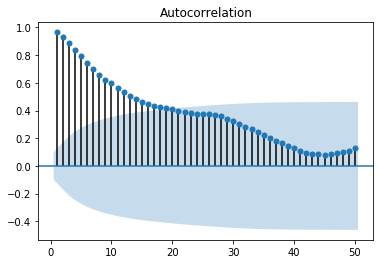

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_dengue, lags = 50, alpha = 0.05, zero = False)
plt.show()

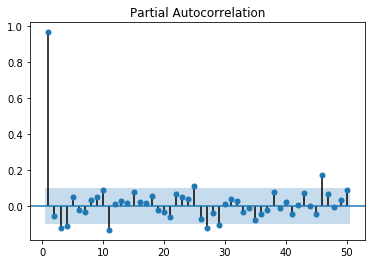

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_dengue, lags = 50, alpha = 0.05, zero = False)
plt.show()

As PACF cuts off at lag 1 and ACF is tailing off, fit a AR(1) model.

In [84]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

ar_1_model = SARIMAX(train_dengue, order = (1,0,0))
results = ar_1_model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  cases   No. Observations:                  409
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -2130.353
Date:                Sat, 28 Mar 2020   AIC                           4264.706
Time:                        21:55:35   BIC                           4272.733
Sample:                    01-02-2012   HQIC                          4267.882
                         - 10-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9864      0.005    203.191      0.000       0.977       0.996
sigma2      1940.4009     83.181     23.327      0.000    1777.369    2103.433
Ljung-Box (Q):                       69.93   Jarque-

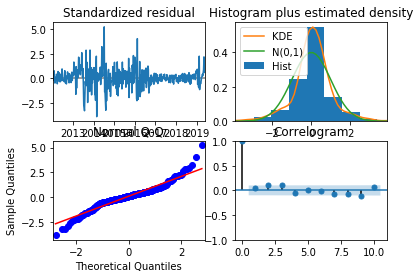

In [18]:
results.plot_diagnostics()
plt.show()

<h1> View how the model performs on test set

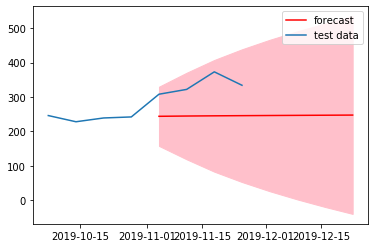

In [101]:
test_forecast = results.get_forecast(steps = len(test_dengue))
mean_forecast = test_forecast.predicted_mean

confidence_intervals = test_forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower cases']
upper_limits = confidence_intervals.loc[:,'upper cases']

plt.figure()
# plt.plot(train_dengue.index, train_dengue['cases'], label = 'observed')
plt.plot(mean_forecast.index, mean_forecast, color = 'r', label = 'forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color = 'pink')
plt.plot(test_dengue.index, test_dengue['cases'], label = 'test data')
plt.legend()
plt.show()

In [102]:
test_score = mean_squared_error(test_y, mean_forecast)
print('Test score for AR(1) model: ', test_score)

Test score for AR(1) model:  4154.0876890488935


<h1> Fit a SARIMA model with single differenced (NTS: Show differenced data and how we get here) </h1>

                                     SARIMAX Results                                      
Dep. Variable:                              cases   No. Observations:                  409
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 24)   Log Likelihood               -2041.658
Date:                            Sat, 28 Mar 2020   AIC                           4091.315
Time:                                    21:56:06   BIC                           4107.128
Sample:                                01-02-2012   HQIC                          4097.587
                                     - 10-28-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9674      0.011     88.407      0.000       0.946       0.989
ma.L1          0.0785      0.036   

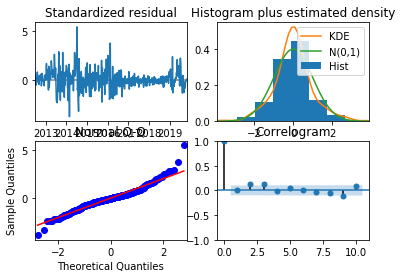

In [87]:
model = SARIMAX(train_dengue, order = (1,0,1), seasonal_order = (0,1,1,24))
results = model.fit()
print(results.summary())
results.plot_diagnostics()
plt.show()

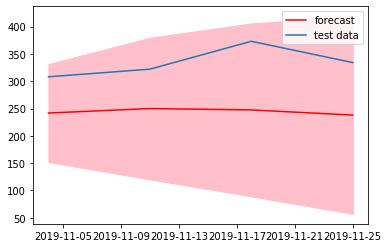

In [88]:
# See predictions on test set
test_forecast = results.get_forecast(steps = len(test_dengue))
mean_forecast = test_forecast.predicted_mean

confidence_intervals = test_forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower cases']
upper_limits = confidence_intervals.loc[:,'upper cases']

plt.figure()
# plt.plot(train_dengue.index, train_dengue['cases'], label = 'observed')
plt.plot(mean_forecast.index, mean_forecast, color = 'r', label = 'forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color = 'pink')
plt.plot(test_dengue.index, test_dengue['cases'], label = 'test data')
plt.legend()
plt.show()

In [89]:
test_score = mean_squared_error(test_y, mean_forecast)
print('Test score for naive SARIMA model: ', test_score)

Test score for naive SARIMA model:  8647.813357402605


<h1> Fit an ARIMA(2,1,2) model </h1>

                               SARIMAX Results                                
Dep. Variable:                  cases   No. Observations:                  409
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2116.630
Date:                Sat, 28 Mar 2020   AIC                           4243.260
Time:                        21:56:29   BIC                           4263.316
Sample:                    01-02-2012   HQIC                          4251.196
                         - 10-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4204      0.030     46.675      0.000       1.361       1.480
ar.L2         -0.9001      0.034    -26.833      0.000      -0.966      -0.834
ma.L1         -1.4048      0.032    -44.181      0.0

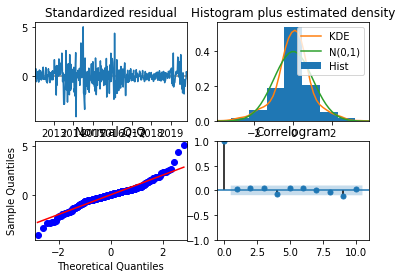

In [90]:
model = SARIMAX(train_dengue, order = (2,1,2))
results = model.fit()
print(results.summary())
results.plot_diagnostics()
plt.show()

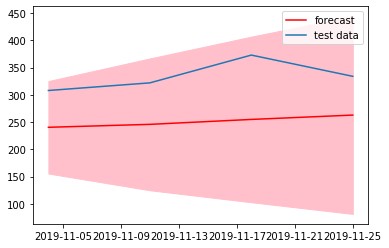

In [91]:
# See predictions on test set
test_forecast = results.get_forecast(steps = len(test_dengue))
mean_forecast = test_forecast.predicted_mean

confidence_intervals = test_forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower cases']
upper_limits = confidence_intervals.loc[:,'upper cases']

plt.figure()
# plt.plot(train_dengue.index, train_dengue['cases'], label = 'observed')
plt.plot(mean_forecast.index, mean_forecast, color = 'r', label = 'forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color = 'pink')
plt.plot(test_dengue.index, test_dengue['cases'], label = 'test data')
plt.legend()
plt.show()

In [92]:
test_score = mean_squared_error(test_y, mean_forecast)
print('Test score for ARIMA(2,1,2) model: ', test_score)

Test score for ARIMA(2,1,2) model:  7342.599354502834


<h1> Fit a (2,2,1) model

                               SARIMAX Results                                
Dep. Variable:                  cases   No. Observations:                  409
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -2119.214
Date:                Sat, 28 Mar 2020   AIC                           4246.427
Time:                        21:56:36   BIC                           4262.462
Sample:                    01-02-2012   HQIC                          4252.773
                         - 10-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0644      0.030      2.141      0.032       0.005       0.123
ar.L2          0.1180      0.035      3.405      0.001       0.050       0.186
ma.L1         -0.9999      0.712     -1.403      0.1

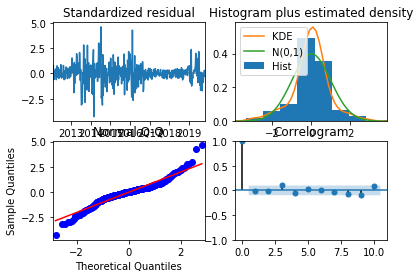

In [93]:
model = SARIMAX(train_dengue, order = (2,2,1))
results = model.fit()
print(results.summary())
results.plot_diagnostics()
plt.show()

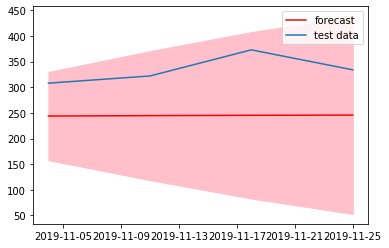

In [94]:
# See predictions on test set
test_forecast = results.get_forecast(steps = len(test_dengue))
mean_forecast = test_forecast.predicted_mean

confidence_intervals = test_forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower cases']
upper_limits = confidence_intervals.loc[:,'upper cases']

plt.figure()
# plt.plot(train_dengue.index, train_dengue['cases'], label = 'observed')
plt.plot(mean_forecast.index, mean_forecast, color = 'r', label = 'forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color = 'pink')
plt.plot(test_dengue.index, test_dengue['cases'], label = 'test data')
plt.legend()
plt.show()

In [95]:
test_score = mean_squared_error(test_y, mean_forecast)
print('Test score for ARIMA(2,2,1) model: ', test_score)

Test score for ARIMA(2,2,1) model:  8555.52838508059


<h1> Fit (2,2,1)(1,0,1,24)

                                     SARIMAX Results                                      
Dep. Variable:                              cases   No. Observations:                  405
Model:             SARIMAX(2, 2, 1)x(1, 0, 1, 24)   Log Likelihood               -2096.525
Date:                            Sat, 28 Mar 2020   AIC                           4205.050
Time:                                    21:31:15   BIC                           4229.043
Sample:                                01-02-2012   HQIC                          4214.549
                                     - 09-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0491      0.031      1.588      0.112      -0.012       0.110
ar.L2          0.1215      0.035   

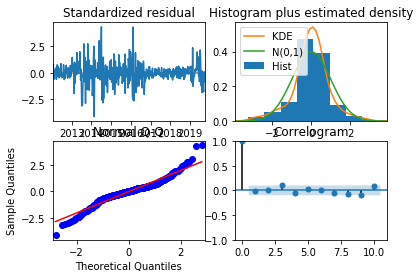

In [60]:
model = SARIMAX(train_dengue, order = (2,2,1), seasonal_order = (1,0,1,24))
results = model.fit()
print(results.summary())
results.plot_diagnostics()
plt.show()

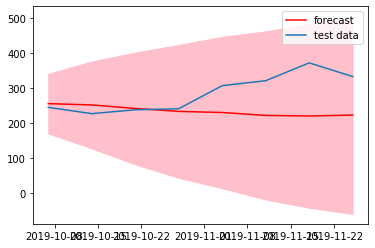

In [62]:
# See predictions on test set
test_forecast = results.get_forecast(steps = len(test_dengue))
mean_forecast = test_forecast.predicted_mean

confidence_intervals = test_forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower cases']
upper_limits = confidence_intervals.loc[:,'upper cases']

plt.figure()
# plt.plot(train_dengue.index, train_dengue['cases'], label = 'observed')
plt.plot(mean_forecast.index, mean_forecast, color = 'r', label = 'forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color = 'pink')
plt.plot(test_dengue.index, test_dengue['cases'], label = 'test data')
plt.legend()
plt.show()

In [63]:
test_score = mean_squared_error(test_y, mean_forecast)
print('Test score for (2,2,1)(1,0,1,24) model: ', test_score)

Test score for (2,2,1)(1,0,1,24) model:  6455.349341584844


<h1> Fit (2,1,2) (1,0,1,52)
 

C:\Users\Ahmad\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                      SARIMAX Results                                       
Dep. Variable:                                cases   No. Observations:                  405
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 52)   Log Likelihood               -2096.178
Date:                              Sat, 28 Mar 2020   AIC                           4206.356
Time:                                      21:31:38   BIC                           4234.365
Sample:                                  01-02-2012   HQIC                          4217.443
                                       - 09-30-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4192      0.030     47.485      0.000       1.361       1.478
ar.L2         -0.90

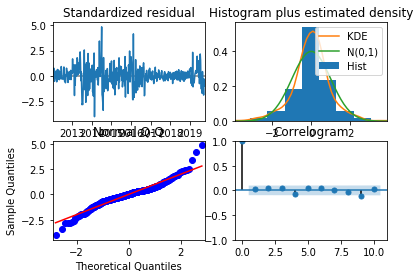

In [64]:
model = SARIMAX(train_dengue, order = (2,1,2), seasonal_order = (1,0,1,52))
results = model.fit()
print(results.summary())
results.plot_diagnostics()
plt.show()

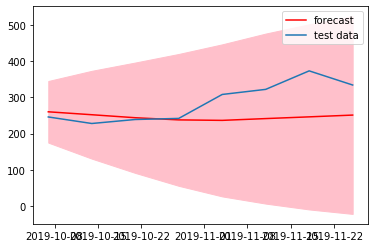

In [65]:
# See predictions on test set
test_forecast = results.get_forecast(steps = len(test_dengue))
mean_forecast = test_forecast.predicted_mean

confidence_intervals = test_forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower cases']
upper_limits = confidence_intervals.loc[:,'upper cases']

plt.figure()
# plt.plot(train_dengue.index, train_dengue['cases'], label = 'observed')
plt.plot(mean_forecast.index, mean_forecast, color = 'r', label = 'forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color = 'pink')
plt.plot(test_dengue.index, test_dengue['cases'], label = 'test data')
plt.legend()
plt.show()

In [104]:
test_score = mean_squared_error(test_y, mean_forecast)
print('Test score for (2,2,1)(1,0,1,24) model: ', test_score)

Test score for (2,2,1)(1,0,1,24) model:  4154.0876890488935
